# Bimodality Test

Goal: develop a test to determine whether a VICE multizone output produces a unimodal or bimodal distribution of [O/Fe].

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/scripts')
from utils import import_apogee, multioutput_to_pandas, get_bin_centers, kl_divergence, apogee_region, filter_multioutput_stars
from feh_distribution import apogee_mdf, vice_mdf

## One- and Two-Gaussian Fits

### Applied to APOGEE data

In [2]:
apogee_data = import_apogee()

The region defined by $5 < R_{\rm{Gal}} < 7$ kpc and $0.5 < |z| < 1$ kpc seems to have the most equal distribution between the high- and low-$\alpha$ sequences in the APOGEE data.

In [3]:
odf, bin_edges = apogee_mdf(apogee_data, col='O_FE', galr_lim=(5, 7), 
                            absz_lim=(0.5, 1), xlim=(-0.15, 0.55), 
                            bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

First, a one-Gaussian fit

In [4]:
class NormalGaussian:
    def __init__(self, center=1, stdev=1):
        self.center = center
        self.stdev = stdev
        self.norm = 1 / (stdev * np.sqrt(2 * np.pi))

    def __call__(self, x):
        return self.norm * np.exp(-(x-self.center)**2 / (2*self.stdev**2))

def one_gaussian(x, center, stdev):
    ng = NormalGaussian(center, stdev)
    return ng(x)

popt1, pcov1 = curve_fit(one_gaussian, ofe_arr, odf, p0=(0.1, 0.05))
fit1 = one_gaussian(ofe_arr, *popt1)
kld1 = kl_divergence(odf, fit1, dx)
print('One-Gaussian KL Divergence =', kld1)

One-Gaussian KL Divergence = 0.13100302871128208


Next, a two-Gaussian fit

In [5]:
def two_gaussian(x, center1, stdev1, coeff1, center2, stdev2):
    ng1 = NormalGaussian(center1, stdev1)
    ng2 = NormalGaussian(center2, stdev2)
    return coeff1 * ng1(x) + (1 - coeff1) * ng2(x)

popt2, pcov2 = curve_fit(two_gaussian, ofe_arr, odf, 
                         p0=(0.1, 0.05, 0.5, 0.3, 0.05))
fit2 = two_gaussian(ofe_arr, *popt2)
kld2 = kl_divergence(odf, fit2, dx)
print('Two-Gaussian KL Divergence =', kld2)

Two-Gaussian KL Divergence = 0.057384196952931246


Plotting to compare

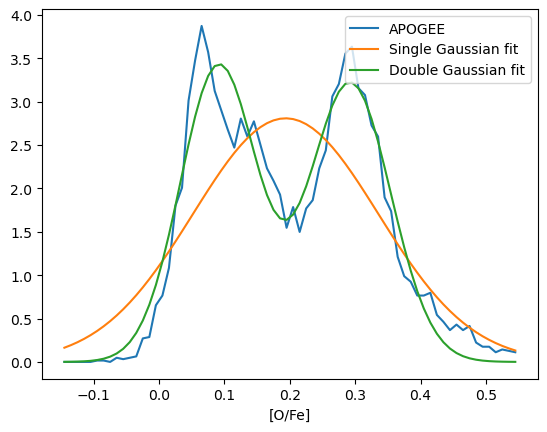

In [6]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='APOGEE')
ax.plot(ofe_arr, fit1, label='Single Gaussian fit')
ax.plot(ofe_arr, fit2, label='Double Gaussian fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

As expected, the two-Gaussian fit is much better than the one-Gaussian fit, as confirmed by the KL divergence.

### Applied to VICE models

In [7]:
vice_onepeak = multioutput_to_pandas('diffusion/insideout/powerlaw_slope11')

In [8]:
odf, bin_edges = vice_mdf(vice_onepeak, col='[o/fe]', galr_lim=(5, 7), 
                          absz_lim=(0.5, 1), xlim=(-0.15, 0.55), 
                          bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

In [9]:
# one Gaussian fit
popt1, pcov1 = curve_fit(one_gaussian, ofe_arr, odf, p0=(0.1, 0.05))
fit1 = one_gaussian(ofe_arr, *popt1)
kld1 = kl_divergence(odf, fit1, dx)
print('One-Gaussian KL Divergence =', kld1)

# two Gaussian fit
popt2, pcov2 = curve_fit(two_gaussian, ofe_arr, odf, 
                         p0=(0.1, 0.05, 0.5, 0.3, 0.05))
fit2 = two_gaussian(ofe_arr, *popt2)
kld2 = kl_divergence(odf, fit2, dx)
print('Two-Gaussian KL Divergence =', kld2)

One-Gaussian KL Divergence = 0.30130089879243577
Two-Gaussian KL Divergence = 0.1265978296625278


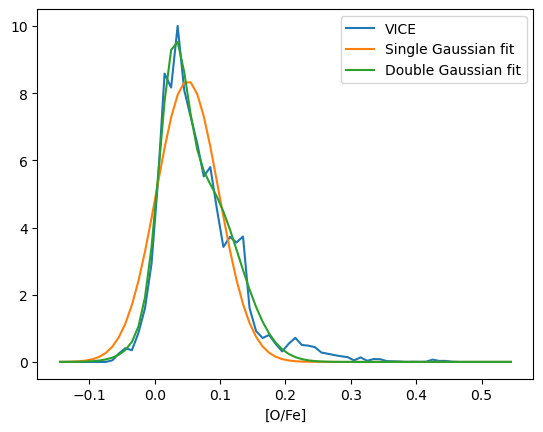

In [10]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='VICE')
ax.plot(ofe_arr, fit1, label='Single Gaussian fit')
ax.plot(ofe_arr, fit2, label='Double Gaussian fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

Unfortunately, even in this clearly unimodal example the two-Gaussian fit has a lower KL divergence.

Restricting the fit parameters doesn't fix things either:

In [11]:
# redefine two-Gaussian fit with equal coefficients
def two_gaussian(x, center1, stdev1, center2, stdev2):
    ng1 = NormalGaussian(center1, stdev1)
    ng2 = NormalGaussian(center2, stdev2)
    return 0.5 * ng1(x) + 0.5 * ng2(x)

# also restrict the two peaks to be below / above [O/Fe] = 0.2
popt2, pcov2 = curve_fit(two_gaussian, ofe_arr, odf, 
                         p0=(0.1, 0.05, 0.3, 0.05),
                         bounds=([-np.inf, -np.inf, 0.2, -np.inf],
                                 [0.2, np.inf, np.inf, np.inf]))
fit2 = two_gaussian(ofe_arr, *popt2)
kld2 = kl_divergence(odf, fit2, dx)
print('Two-Gaussian KL Divergence =', kld2)

Two-Gaussian KL Divergence = 0.2816859442428302


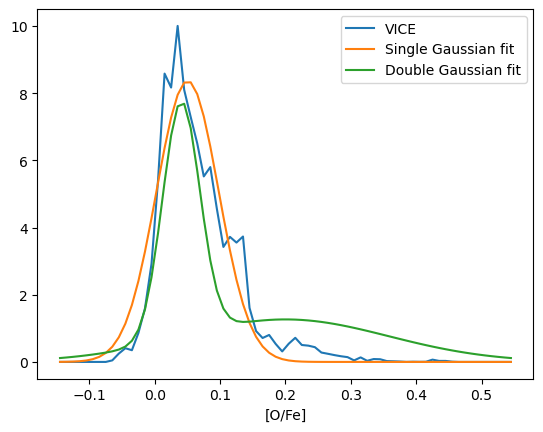

In [12]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='VICE')
ax.plot(ofe_arr, fit1, label='Single Gaussian fit')
ax.plot(ofe_arr, fit2, label='Double Gaussian fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

The KL divergence is higher, but still smaller than the one-Gaussian test.

Additionally, there are some models which produce an _overall_ bimodal distribution in [O/Fe], but not a bimodal distribution in this particular region of the Galaxy.

In [13]:
vice_twopeak = multioutput_to_pandas('diffusion/conroy22/powerlaw_slope11')

In [14]:
odf, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', galr_lim=(5, 7), 
                          absz_lim=(0.5, 1), xlim=(-0.15, 0.55), 
                          bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

In [15]:
# one Gaussian fit
popt1, pcov1 = curve_fit(one_gaussian, ofe_arr, odf, p0=(0.1, 0.05))
fit1 = one_gaussian(ofe_arr, *popt1)
kld1 = kl_divergence(odf, fit1, dx)
print('One-Gaussian KL Divergence =', kld1)

# two Gaussian fit
popt2, pcov2 = curve_fit(two_gaussian, ofe_arr, odf, 
                         p0=(0.1, 0.05, 0.3, 0.05),
                         bounds=([-np.inf, -np.inf, 0.2, -np.inf],
                                 [0.2, np.inf, np.inf, np.inf]))
fit2 = two_gaussian(ofe_arr, *popt2)
kld2 = kl_divergence(odf, fit2, dx)
print('Two-Gaussian KL Divergence =', kld2)

One-Gaussian KL Divergence = 0.11780705418090957
Two-Gaussian KL Divergence = 0.05909748580812241


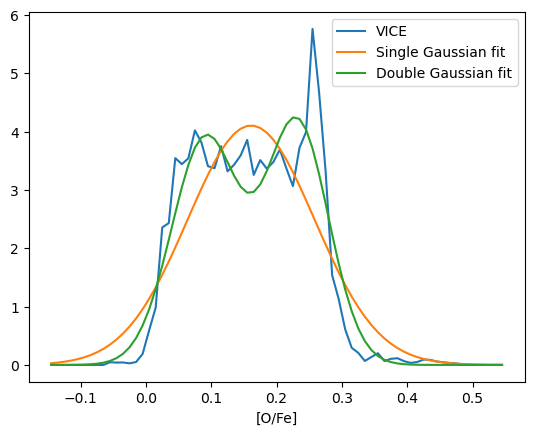

In [16]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='VICE')
ax.plot(ofe_arr, fit1, label='Single Gaussian fit')
ax.plot(ofe_arr, fit2, label='Double Gaussian fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

## One-Gaussian Fits in Two Different Regions

Rather than looking for bimodality within a single region of the Galaxy, compare the location of the peaks in two disparate regions of the galaxy: high latitudes and small radii, and low latitudes and large radii. If the best-fit Gaussians are significantly different from each other, then we consider the overall distribution to be bimodal.

### In APOGEE

In [17]:
odf_inner, bin_edges = apogee_mdf(apogee_data, col='O_FE', 
                                  galr_lim=(3, 5), absz_lim=(1, 2), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = apogee_mdf(apogee_data, col='O_FE', 
                                  galr_lim=(13, 15), absz_lim=(0, 0.5), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

# inner region fit
popt1, pcov1 = curve_fit(stats.norm.pdf, ofe_arr, odf_inner, p0=(0.3, 0.05))
print('Inner region: center =', popt1[0], ', stdev =', popt1[1])
fit1 = stats.norm.pdf(ofe_arr, *popt1)

# outer region fit
popt2, pcov2 = curve_fit(stats.norm.pdf, ofe_arr, odf_outer, p0=(0.1, 0.05))
print('Outer region: center =', popt2[0], ', stdev =', popt2[1])
fit2 = stats.norm.pdf(ofe_arr, *popt2)

Inner region: center = 0.31582465732477577 , stdev = 0.051144083560063315
Outer region: center = 0.11142313636930631 , stdev = 0.04418141210389215


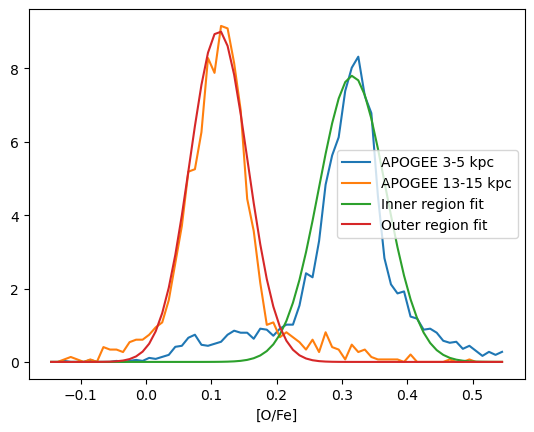

In [18]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='APOGEE 3-5 kpc')
ax.plot(ofe_arr, odf_outer, label='APOGEE 13-15 kpc')
ax.plot(ofe_arr, fit1, label='Inner region fit')
ax.plot(ofe_arr, fit2, label='Outer region fit')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

Are these two fits distinct?

In [19]:
rms_err = np.sqrt(0.5 * (popt1[1]**2 + popt2[1]**2))
center_diff = popt1[0] - popt2[0]
print(center_diff / rms_err)

4.277102393636982


### In VICE

First, looking at a model I would conisider clearly bimodal:

In [20]:
odf_inner, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', 
                                  galr_lim=(3, 5), absz_lim=(1, 2), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', 
                                  galr_lim=(13, 15), absz_lim=(0, 0.5), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

# inner region fit
popt1, pcov1 = curve_fit(one_gaussian, ofe_arr, odf_inner, p0=(0.3, 0.05))
print('Inner region: center =', popt1[0], ', stdev =', popt1[1])
fit1 = one_gaussian(ofe_arr, *popt1)

# outer region fit
popt2, pcov2 = curve_fit(one_gaussian, ofe_arr, odf_outer, p0=(0.1, 0.05))
print('Outer region: center =', popt2[0], ', stdev =', popt2[1])
fit2 = one_gaussian(ofe_arr, *popt2)

Inner region: center = 0.2587687330156706 , stdev = 0.04483633316738871
Outer region: center = 0.055028593032841064 , stdev = 0.05162244969756827


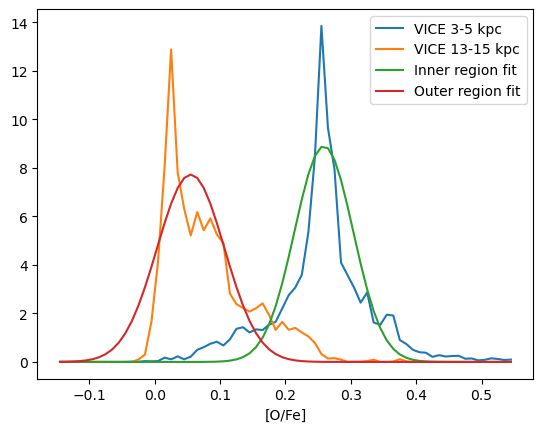

In [21]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='VICE 3-5 kpc')
ax.plot(ofe_arr, odf_outer, label='VICE 13-15 kpc')
ax.plot(ofe_arr, fit1, label='Inner region fit')
ax.plot(ofe_arr, fit2, label='Outer region fit')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

In [22]:
rms_err = np.sqrt(0.5 * (popt1[1]**2 + popt2[1]**2))
center_diff = popt1[0] - popt2[0]
print(center_diff / rms_err)

4.213982275654513


Next, a model which I would consider clearly unimodal:

In [23]:
odf_inner, bin_edges = vice_mdf(vice_onepeak, col='[o/fe]', 
                                  galr_lim=(3, 5), absz_lim=(1, 2), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = vice_mdf(vice_onepeak, col='[o/fe]', 
                                  galr_lim=(13, 15), absz_lim=(0, 0.5), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

# inner region fit
popt1, pcov1 = curve_fit(one_gaussian, ofe_arr, odf_inner, p0=(0.3, 0.05))
print('Inner region: center =', popt1[0], ', stdev =', popt1[1])
fit1 = one_gaussian(ofe_arr, *popt1)

# outer region fit
popt2, pcov2 = curve_fit(one_gaussian, ofe_arr, odf_outer, p0=(0.1, 0.05))
print('Outer region: center =', popt2[0], ', stdev =', popt2[1])
fit2 = one_gaussian(ofe_arr, *popt2)

Inner region: center = 0.1278466281715298 , stdev = 0.0713889216049692
Outer region: center = 0.014141634692516796 , stdev = 0.031140868835577058


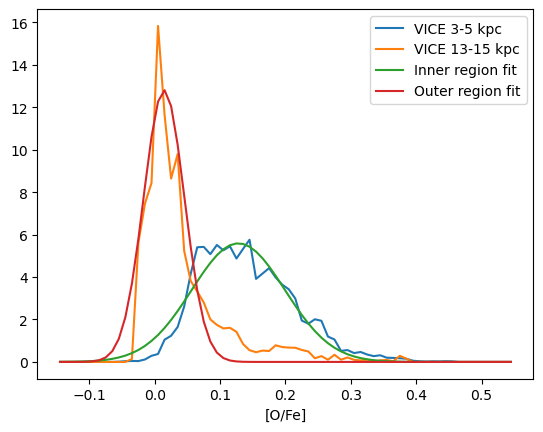

In [24]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='VICE 3-5 kpc')
ax.plot(ofe_arr, odf_outer, label='VICE 13-15 kpc')
ax.plot(ofe_arr, fit1, label='Inner region fit')
ax.plot(ofe_arr, fit2, label='Outer region fit')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

In [25]:
rms_err = np.sqrt(0.5 * (popt1[1]**2 + popt2[1]**2))
center_diff = popt1[0] - popt2[0]
print(center_diff / rms_err)

2.0646127880269214


Here's a border case where the significance falls just short of 3-sigma.

In [26]:
vice_edgecase = multioutput_to_pandas('diffusion/insideout/exponential_timescale30')

In [27]:
odf_inner, bin_edges = vice_mdf(vice_edgecase, col='[o/fe]', 
                                  galr_lim=(3, 5), absz_lim=(1, 2), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = vice_mdf(vice_edgecase, col='[o/fe]', 
                                  galr_lim=(13, 15), absz_lim=(0, 0.5), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

# inner region fit
popt1, pcov1 = curve_fit(one_gaussian, ofe_arr, odf_inner, p0=(0.3, 0.05))
print('Inner region: center =', popt1[0], ', stdev =', popt1[1])
fit1 = one_gaussian(ofe_arr, *popt1)

# outer region fit
popt2, pcov2 = curve_fit(one_gaussian, ofe_arr, odf_outer, p0=(0.1, 0.05))
print('Outer region: center =', popt2[0], ', stdev =', popt2[1])
fit2 = one_gaussian(ofe_arr, *popt2)

Inner region: center = 0.25502831953912625 , stdev = 0.09368912168454947
Outer region: center = 0.02567554543335391 , stdev = 0.05799687509986848


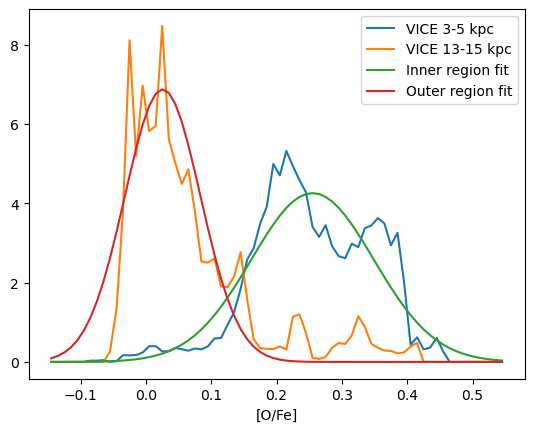

In [28]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='VICE 3-5 kpc')
ax.plot(ofe_arr, odf_outer, label='VICE 13-15 kpc')
ax.plot(ofe_arr, fit1, label='Inner region fit')
ax.plot(ofe_arr, fit2, label='Outer region fit')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

In [29]:
rms_err = np.sqrt(0.5 * (popt1[1]**2 + popt2[1]**2))
center_diff = popt1[0] - popt2[0]
print(center_diff / rms_err)

2.9436528806457747


## KS test

### APOGEE

In [30]:
inner_region = apogee_region(apogee_data, galr_lim=(3, 5), absz_lim=(0.5, 1))
outer_region = apogee_region(apogee_data, galr_lim=(11, 13), absz_lim=(0.5, 1))

# KS test: are the two samples drawn from the same population?
stats.kstest(inner_region['O_FE'], outer_region['O_FE'], alternative='less')

KstestResult(statistic=0.5558217131061247, pvalue=0.0)

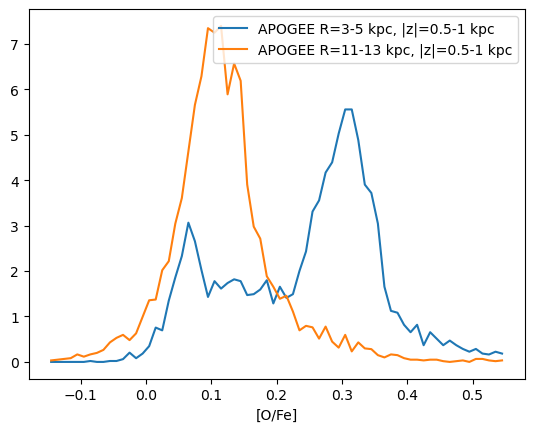

In [31]:
odf_inner, bin_edges = apogee_mdf(apogee_data, col='O_FE', 
                                  galr_lim=(3, 5), absz_lim=(0.5, 1), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = apogee_mdf(apogee_data, col='O_FE', 
                                  galr_lim=(11, 13), absz_lim=(0.5, 1), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='APOGEE R=3-5 kpc, |z|=0.5-1 kpc')
ax.plot(ofe_arr, odf_outer, label='APOGEE R=11-13 kpc, |z|=0.5-1 kpc')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

In [32]:
inner_region = apogee_region(apogee_data, galr_lim=(9, 11), absz_lim=(0, 0.5))
outer_region = apogee_region(apogee_data, galr_lim=(11, 13), absz_lim=(0, 0.5))

# KS test: are the two samples drawn from the same population?
stats.kstest(inner_region['O_FE'], outer_region['O_FE'], alternative='less')

KstestResult(statistic=0.007852384010973434, pvalue=0.3716937482403747)

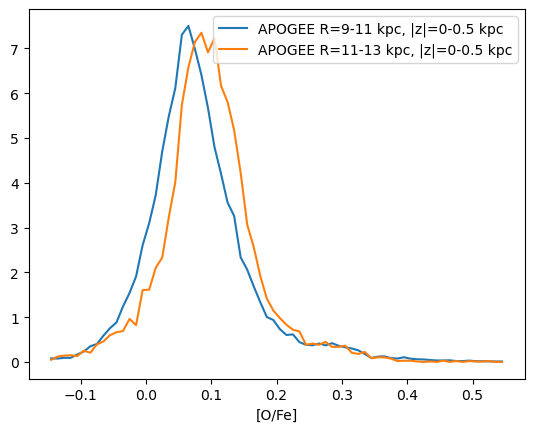

In [33]:
odf_inner, bin_edges = apogee_mdf(apogee_data, col='O_FE', 
                                  galr_lim=(9, 11), absz_lim=(0, 0.5), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = apogee_mdf(apogee_data, col='O_FE', 
                                  galr_lim=(11, 13), absz_lim=(0, 0.5), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='APOGEE R=9-11 kpc, |z|=0-0.5 kpc')
ax.plot(ofe_arr, odf_outer, label='APOGEE R=11-13 kpc, |z|=0-0.5 kpc')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

### VICE

An obviously bimodal case

In [34]:
inner_region = filter_multioutput_stars(vice_twopeak, galr_lim=(3, 5), absz_lim=(0.5, 1), min_mass=1)
outer_region = filter_multioutput_stars(vice_twopeak, galr_lim=(11, 13), absz_lim=(0.5, 1), min_mass=1)
stats.kstest(inner_region['[o/fe]'], outer_region['[o/fe]'], alternative='less')

KstestResult(statistic=0.49390050651676887, pvalue=0.0)

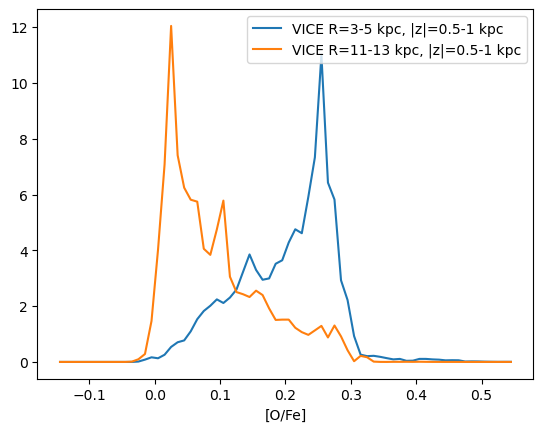

In [35]:
odf_inner, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', 
                                  galr_lim=(3, 5), absz_lim=(0.5, 1), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', 
                                  galr_lim=(11, 13), absz_lim=(0.5, 1), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='VICE R=3-5 kpc, |z|=0.5-1 kpc')
ax.plot(ofe_arr, odf_outer, label='VICE R=11-13 kpc, |z|=0.5-1 kpc')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

An obviously unimodal case

In [36]:
inner_region = filter_multioutput_stars(vice_onepeak, galr_lim=(3, 5), absz_lim=(0.5, 1), min_mass=1)
outer_region = filter_multioutput_stars(vice_onepeak, galr_lim=(11, 13), absz_lim=(0.5, 1), min_mass=1)
stats.kstest(inner_region['[o/fe]'], outer_region['[o/fe]'], alternative='less')

KstestResult(statistic=0.45972672252032976, pvalue=0.0)

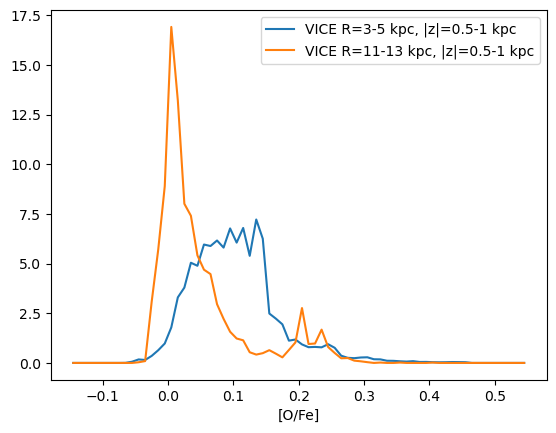

In [37]:
odf_inner, bin_edges = vice_mdf(vice_onepeak, col='[o/fe]', 
                                  galr_lim=(3, 5), absz_lim=(0.5, 1), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
odf_outer, bin_edges = vice_mdf(vice_onepeak, col='[o/fe]', 
                                  galr_lim=(11, 13), absz_lim=(0.5, 1), 
                                  xlim=(-0.15, 0.55), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

fig, ax = plt.subplots()
ax.plot(ofe_arr, odf_inner, label='VICE R=3-5 kpc, |z|=0.5-1 kpc')
ax.plot(ofe_arr, odf_outer, label='VICE R=11-13 kpc, |z|=0.5-1 kpc')
ax.legend()
ax.set_xlabel('[O/Fe]')
plt.show()

## Skew-Normal Distributions

### APOGEE

In [55]:
odf, bin_edges = apogee_mdf(apogee_data, col='O_FE', galr_lim=(5, 7), 
                            absz_lim=(0.5, 1), xlim=(-0.2, 0.6), 
                            bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

In [62]:
# one curve fit
popt1, pcov1 = curve_fit(stats.skewnorm.pdf, ofe_arr, odf, p0=(0, 0.2, 0.1))
print('skewness =', popt1[0], ', center =', popt1[1], 'stdev =', popt1[2])
fit1 = stats.skewnorm.pdf(ofe_arr, *popt1)
# KL-divergence test
kld1 = kl_divergence(odf, fit1, dx)
print('KL divergence =', kld1)

skewness = 12.903376582846974 , center = 0.022336518589691785 stdev = 0.2533401750197438
KL divergence = 0.11809464297069688


In [63]:
# two curve fit
def two_skewnorm(x, a1, loc1, scale1, norm1, a2, loc2, scale2):
    return norm1 * stats.skewnorm.pdf(x, a1, loc1, scale1) + (1 - norm1) * stats.skewnorm.pdf(x, a2, loc2, scale2)

popt2, pcov2 = curve_fit(two_skewnorm, ofe_arr, odf, p0=(0, 0.1, 0.05, 0.5, 0, 0.3, 0.05))
print('First peak: skewness =', popt2[0], ', center =', popt2[1], 'stdev =', popt2[2], 'norm =', popt2[3])
print('Second peak: skewness =', popt2[4], ', center =', popt2[5], 'stdev =', popt2[6], 'norm =', 1 - popt2[3])
fit2 = two_skewnorm(ofe_arr, *popt2)
# KL-divergence test
kld2 = kl_divergence(odf, fit2, dx)
print('KL divergence =', kld2)

First peak: skewness = 6.171634509954135 , center = 0.023532793740350284 stdev = 0.14495842030546954 norm = 0.6576628456873965
Second peak: skewness = 3.5343181439034086 , center = 0.2550611815960274 stdev = 0.08288028043836647 norm = 0.3423371543126035
KL divergence = 0.027410955767592955


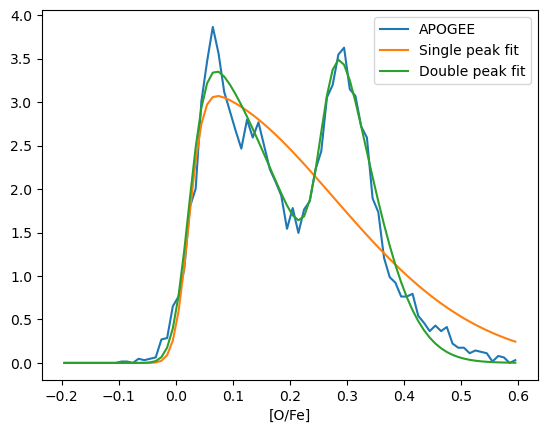

In [58]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='APOGEE')
ax.plot(ofe_arr, fit1, label='Single peak fit')
ax.plot(ofe_arr, fit2, label='Double peak fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

### VICE unimodal

In [84]:
odf, bin_edges = vice_mdf(vice_onepeak, col='[o/fe]', galr_lim=(5, 7), 
                          absz_lim=(0.5, 1), xlim=(-0.2, 0.6), 
                          bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

In [86]:
# one curve fit
popt1, pcov1 = curve_fit(stats.skewnorm.pdf, ofe_arr, odf, p0=(0, 0.2, 0.1))
print('skewness =', popt1[0], ', center =', popt1[1], 'stdev =', popt1[2])
fit1 = stats.skewnorm.pdf(ofe_arr, *popt1)
# KL-divergence test
kld1 = kl_divergence(odf, fit1, dx)
print('KL divergence =', kld1)
# reduced chi-square test
chisq1 = stats.chisquare(odf, fit1)
print('Chi-square =', chisq1[0])

skewness = 5.4654981903900435 , center = 0.0002885928382719811 stdev = 0.08230540057422472
KL divergence = 0.07828695949052056
Chi-square = 773.0964288503208


In [89]:
# two curve fit
popt2, pcov2 = curve_fit(two_skewnorm, ofe_arr, odf, p0=(0, 0.1, 0.05, 0.5, 0, 0.3, 0.05))
print('First peak: skewness =', popt2[0], ', center =', popt2[1], 'stdev =', popt2[2], 'norm =', popt2[3])
print('Second peak: skewness =', popt2[4], ', center =', popt2[5], 'stdev =', popt2[6], 'norm =', 1 - popt2[3])
fit2 = two_skewnorm(ofe_arr, *popt2)
# KL-divergence test
kld2 = kl_divergence(odf, fit2, dx)
print('KL divergence =', kld2)
# reduced chi-square test
chisq2 = stats.chisquare(odf, fit2 / (np.sum(fit2) * dx))
print('Chi-square =', chisq2[0])

First peak: skewness = 5.480931554349232 , center = 0.0009388795108552546 stdev = 0.07984862952168402 norm = 0.9601690433941309
Second peak: skewness = -4.781305576674119 , center = 0.45388149139143563 stdev = 0.0005197818668778095 norm = 0.039830956605869106
KL divergence = 0.13198736307674477
Chi-square = 1681.1338675292723


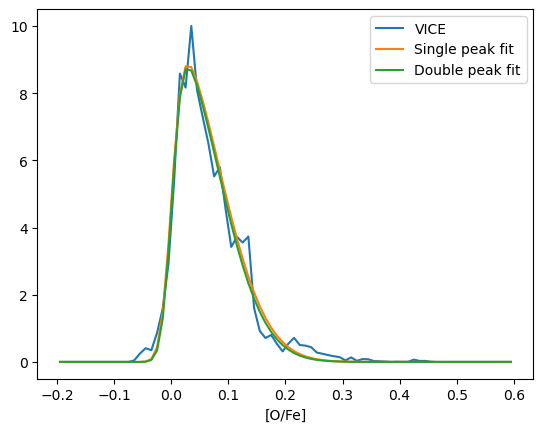

In [90]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='VICE')
ax.plot(ofe_arr, fit1, label='Single peak fit')
ax.plot(ofe_arr, fit2, label='Double peak fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

### VICE bimodal

In [91]:
odf, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', galr_lim=(5, 7), 
                          absz_lim=(0.5, 1), xlim=(-0.2, 0.6), 
                          bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

In [98]:
# one curve fit
popt1, pcov1 = curve_fit(stats.skewnorm.pdf, ofe_arr, odf, p0=(0, 0.2, 0.1))
print('skewness =', popt1[0], ', center =', popt1[1], 'stdev =', popt1[2])
fit1 = stats.skewnorm.pdf(ofe_arr, *popt1)
# KL-divergence test
kld1 = kl_divergence(odf, fit1, dx)
print('KL divergence =', kld1)
# reduced chi-square test
chisq1 = stats.chisquare(odf, fit1 / (np.sum(fit1) * dx))
print('Chi-square =', chisq1[0])

skewness = -0.30784862171544886 , center = 0.18437069103521928 stdev = 0.10001942052140192
KL divergence = 0.11790220888051955
Chi-square = 20.649537097334044


In [99]:
# two curve fit
popt2, pcov2 = curve_fit(two_skewnorm, ofe_arr, odf, p0=(0, 0.1, 0.05, 0.5, 0, 0.3, 0.05))
print('First peak: skewness =', popt2[0], ', center =', popt2[1], 'stdev =', popt2[2], 'norm =', popt2[3])
print('Second peak: skewness =', popt2[4], ', center =', popt2[5], 'stdev =', popt2[6], 'norm =', 1 - popt2[3])
fit2 = two_skewnorm(ofe_arr, *popt2)
# KL-divergence test
kld2 = kl_divergence(odf, fit2, dx)
print('KL divergence =', kld2)
# reduced chi-square test
chisq2 = stats.chisquare(odf, fit2 / (np.sum(fit2) * dx))
print('Chi-square =', chisq2[0])

First peak: skewness = 6.067358558457352 , center = 0.027760958297005634 stdev = 0.1346703940470714 norm = 0.7064176958926631
Second peak: skewness = -7.47898980094411 , center = 0.27973459448940674 stdev = 0.06239106696944623 norm = 0.2935823041073369
KL divergence = 0.014807101274516038
Chi-square = 9.288612175967115


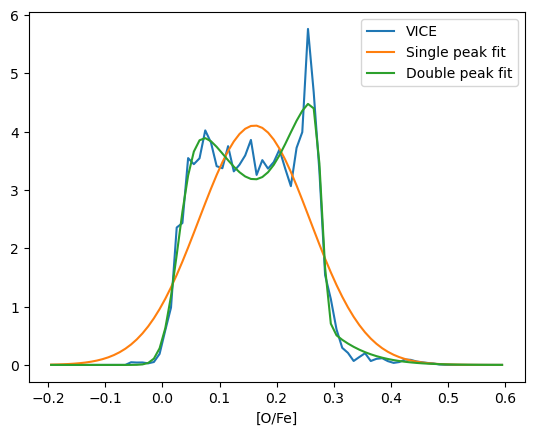

In [95]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='VICE')
ax.plot(ofe_arr, fit1, label='Single peak fit')
ax.plot(ofe_arr, fit2, label='Double peak fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()

### Larger region

In [77]:
odf, bin_edges = vice_mdf(vice_twopeak, col='[o/fe]', 
                          galr_lim=(3, 9), absz_lim=(0.5, 1), 
                          xlim=(-0.2, 0.6), bin_width=0.01, smoothing=False)
dx = bin_edges[1] - bin_edges[0]
ofe_arr = get_bin_centers(bin_edges)

In [78]:
# one curve fit
popt1, pcov1 = curve_fit(stats.skewnorm.pdf, ofe_arr, odf, p0=(0, 0.2, 0.1))
print('skewness =', popt1[0], ', center =', popt1[1], 'stdev =', popt1[2])
fit1 = stats.skewnorm.pdf(ofe_arr, *popt1)
# KL-divergence test
kld1 = kl_divergence(odf, fit1, dx)
print('KL divergence =', kld1)

skewness = -12.669156758101312 , center = 0.28571104672087283 stdev = 0.17288893026427185
KL divergence = 0.6045001006242734


In [79]:
# two curve fit
popt2, pcov2 = curve_fit(two_skewnorm, ofe_arr, odf, p0=(0, 0.1, 0.05, 0.5, 0, 0.3, 0.05))
print('First peak: skewness =', popt2[0], ', center =', popt2[1], 'stdev =', popt2[2], 'norm =', popt2[3])
print('Second peak: skewness =', popt2[4], ', center =', popt2[5], 'stdev =', popt2[6], 'norm =', 1 - popt2[3])
fit2 = two_skewnorm(ofe_arr, *popt2)
# KL-divergence test
kld2 = kl_divergence(odf, fit2, dx)
print('KL divergence =', kld2)

First peak: skewness = 5.909322336009511 , center = 0.02018871791748769 stdev = 0.147589512711439 norm = 0.6820288211142747
Second peak: skewness = -4.980468214089702 , center = 0.2792046987518609 stdev = 0.05674232771862911 norm = 0.31797117888572535
KL divergence = 0.015727553781758868


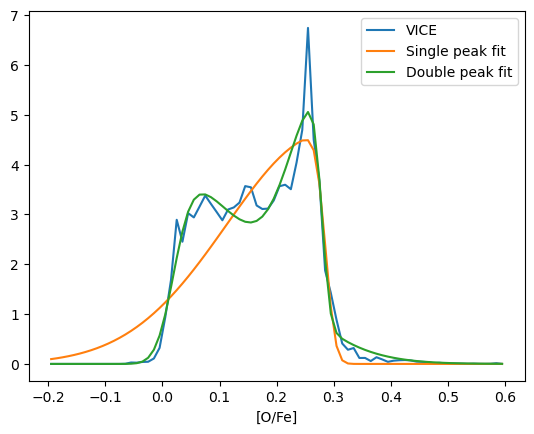

In [80]:
fig, ax = plt.subplots()
ax.plot(ofe_arr, odf, label='VICE')
ax.plot(ofe_arr, fit1, label='Single peak fit')
ax.plot(ofe_arr, fit2, label='Double peak fit')
ax.legend(loc='upper right')
ax.set_xlabel('[O/Fe]')
plt.show()